## Preparação dos dados para construção de Machine Learning para a ONG Passos Mágicos.
 
#### Os modelos de Machine Learning que serão aqui construídos serão utilizados para prever:
#### -  se o aluno esta elegível para a obtenção de uma BOLSA DE ESTUDOS ou
#### -  se o aluno se esta elegível para alcance do PONTO DE VIRADA.

In [2]:
import re
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
from scipy.stats import gaussian_kde
import numpy as np

pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('MODEL_DATASET.csv', sep=';',encoding="latin-1")
df.head()     

,INSTITUICAO_ENSINO_ALUNO_2020,NOME,IDADE_ALUNO_2020,ANOS_PM_2020,FASE_TURMA_2020,PONTO_VIRADA_2020,INDE_2020,INDE_CONCEITO_2020,PEDRA_2020,DESTAQUE_IEG_2020,DESTAQUE_IDA_2020,DESTAQUE_IPV_2020,IAA_2020,IEG_2020,IPS_2020,IDA_2020,IPP_2020,IPV_2020,IAN_2020,FASE_2021,TURMA_2021,INSTITUICAO_ENSINO_ALUNO_2021,SINALIZADOR_INGRESSANTE_2021,PEDRA_2021,INDE_2021,IAA_2021,IEG_2021,IPS_2021,IDA_2021,IPP_2021,REC_EQUIPE_1_2021,REC_EQUIPE_2_2021,REC_EQUIPE_3_2021,REC_EQUIPE_4_2021,PONTO_VIRADA_2021,IPV_2021,IAN_2021,NIVEL_IDEAL_2021,DEFASAGEM_2021,FASE_2022,TURMA_2022,ANO_INGRESSO_2022,BOLSISTA_2022,INDE_2022,CG_2022,CF_2022,CT_2022,PEDRA_2022,DESTAQUE_IEG_2022,DESTAQUE_IDA_2022,DESTAQUE_IPV_2022,IAA_2022,IEG_2022,IPS_2022,IDA_2022,NOTA_PORT_2022,NOTA_MAT_2022,NOTA_ING_2022,QTD_AVAL_2022,IPP_2022,REC_AVA_1_2022,REC_AVA_2_2022,REC_AVA_3_2022,REC_AVA_4_2022,INDICADO_BOLSA_2022,PONTO_VIRADA_2022,IPV_2022,IAN_2022,NIVEL_IDEAL_2022
0,Escola PÃºblica,ALUNO-1,11,2,2H,NÃ£o,7.883752,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integraÃ§Ã£o a...,8.500020000000001,8.7,7.5,7,5.9375,7.75,10,2.0,G,Rede DecisÃ£o,Ingressante,Ametista,7.319,7.5,6.3,6.9,8.8,7.7,Promovido de Fase,Promovido de Fase,Mantido na Fase atual,NÃ£o avaliado,NÃ£o,8.1,5.0,NÃ­vel 3 (7o e 8o ano),-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,ALUNO-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,K,2022.0,NÃ£o,7.675509,245.0,66.0,6.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Destaque: As suas boas notas na Passos MÃ¡gicos.,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,10.00002,7.581705,7.5,8.816667,8.200000,9.433333,NaN,2.0,5.625000,Mantido na Fase + Bolsa,Mantido na Fase atual,NaN,NaN,Sim,NÃ£o,7.916665,5.0,Fase 2 (5Âº e 6Âº ano)
2,Escola PÃºblica,ALUNO-3,12,2,3H,NÃ£o,7.856389666666666,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integraÃ§Ã£o a...,7.91667,8.9,7.5,5.5,8.125,8.111113333333334,10,3.0,F,Escola PÃºblica,Veterano,Ametista,7.021,7.1,6.9,6.3,5.6,7.3,Promovido de Fase,Promovido de Fase,Mantido na Fase atual,NÃ£o avaliado,NÃ£o,7.2,10.0,NÃ­vel 3 (7o e 8o ano),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Escola PÃºblica,ALUNO-4,10,2,1D,NÃ£o,5.076252,D,Quartzo,Ponto a melhorar em 2021: Melhorar a sua entre...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Ponto a melhorar em 2021: Integrar-se mais aos...,8.000020000000001,4.1,6.875,0,7.1875,7.75,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,J,2022.0,NÃ£o,7.117065,451.0,69.0,3.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,10.00002,8.071429,7.5,5.083333,5.000000,5.166667,NaN,3.0,6.250000,Promovido de Fase,Mantido na Fase atual,Promovido de Fase,NaN,NÃ£o,NÃ£o,8.055553,5.0,Fase 3 (7Âº e 8Âº ano)
4,Escola PÃºblica,ALUNO-5,10,1,2M,NÃ£o,8.077085,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Seu destaque em 2020: As suas boas notas na Pa...,Seu destaque em 2020: A sua boa integraÃ§Ã£o a...,7.50002,8,7.5,7.5,8.4375,8.166665,10,2.0,L,Escola PÃºblica,Veterano,Ametista,7.399,7.4,7.5,7.5,5.4,8.5,Promovido de Fase,Mantido na Fase atual,Mantido na Fase atual,NÃ£o avaliado,NÃ£o,7.4,10.0,NÃ­vel 2 (5o e 6o ano),0.0,2.0,L,2019.0,NÃ£o,7.232336,415.0,61.0,12.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,6.41668,8.557505,7.5,7.083333,6.666667,7.500000,NaN,3.0,6.458333,Mantido na Fase atual,Pr

In [6]:
df['PONTO_VIRADA_2021'].value_counts()

PONTO_VIRADA_2021
NÃ£o      576
Sim       108
#NULO!      2
Name: count, dtype: int64

In [7]:
df_analysis = df[['NOME', 'PONTO_VIRADA_2021']].isin(['#NULO!'])
df_analysis[df_analysis['PONTO_VIRADA_2021'] == True]
# will remove these in a function later on, with NaN

,NOME,PONTO_VIRADA_2021
70,False,True
505,False,True


In [8]:
indicadores = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN']

In [9]:
def extract_columns_for_year(dataframe, year):
    regex_pattern = re.compile(f'.*_{year}$')
    columns_for_year = [column for column in dataframe.columns if regex_pattern.match(column) or column == 'NOME']
    filtered_dataframe = dataframe[columns_for_year].copy()
    filtered_dataframe['ANO'] = year
    filtered_dataframe.columns = [re.sub(f'_{year}$', '', column) for column in filtered_dataframe.columns]

    return filtered_dataframe

def clean_dataframe(dataframe):
    # Drop rows where all columns except 'NOME' and 'ANO' are NaN
    temp_df = dataframe.dropna(subset=dataframe.columns.difference(['NOME', 'ANO']), how='all')
    # Remove rows that are entirely NaN
    temp_df = temp_df[~temp_df.isna().all(axis=1)]
    # remove rows where we have #NULO! in any of the columns
    temp_df = temp_df[~temp_df.isin(['#NULO!']).any(axis=1)]
    return temp_df.dropna(subset=['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN'], how='all')

def process_yearly_data(dataframe, year: int) -> pd.DataFrame:
    filtered_dataframe = extract_columns_for_year(dataframe, year)
    year_specific_df = filtered_dataframe.query('ANO == @year')

    # Convert indicator columns to numeric, forcing errors to NaN
    indicadores = ['INDE', 'IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN']
    year_specific_df[indicadores] = year_specific_df[indicadores].apply(lambda column: pd.to_numeric(column, errors='coerce'))

    # Generate a cleaned version of the dataframe without NaNs
    cleaned_year_df = clean_dataframe(year_specific_df)
    
    return cleaned_year_df

In [10]:
# quebra o df original por ano
df_2020_cleaned = process_yearly_data(df, 2020)
df_2021_cleaned = process_yearly_data(df, 2021)
df_2022_cleaned = process_yearly_data(df, 2022)

In [11]:
busca_string_invalida = df_2020_cleaned.map(lambda x: x == '#NULO!')
df_2020_cleaned[busca_string_invalida.any(axis=1)]

,INSTITUICAO_ENSINO_ALUNO,NOME,IDADE_ALUNO,ANOS_PM,FASE_TURMA,PONTO_VIRADA,INDE,INDE_CONCEITO,PEDRA,DESTAQUE_IEG,DESTAQUE_IDA,DESTAQUE_IPV,IAA,IEG,IPS,IDA,IPP,IPV,IAN,ANO


In [12]:
busca_string_invalida = df_2021_cleaned.map(lambda x: x == '#NULO!')
df_2021_cleaned[busca_string_invalida.any(axis=1)]

,NOME,FASE,TURMA,INSTITUICAO_ENSINO_ALUNO,SINALIZADOR_INGRESSANTE,PEDRA,INDE,IAA,IEG,IPS,IDA,IPP,REC_EQUIPE_1,REC_EQUIPE_2,REC_EQUIPE_3,REC_EQUIPE_4,PONTO_VIRADA,IPV,IAN,NIVEL_IDEAL,DEFASAGEM,ANO


In [13]:
busca_string_invalida = df_2022_cleaned.map(lambda x: x == '#NULO!')
df_2022_cleaned[busca_string_invalida.any(axis=1)]

,NOME,FASE,TURMA,ANO_INGRESSO,BOLSISTA,INDE,CG,CF,CT,PEDRA,DESTAQUE_IEG,DESTAQUE_IDA,DESTAQUE_IPV,IAA,IEG,IPS,IDA,NOTA_PORT,NOTA_MAT,NOTA_ING,QTD_AVAL,IPP,REC_AVA_1,REC_AVA_2,REC_AVA_3,REC_AVA_4,INDICADO_BOLSA,PONTO_VIRADA,IPV,IAN,NIVEL_IDEAL,ANO


In [14]:
df_concat = pd.concat([df_2020_cleaned, df_2021_cleaned, df_2022_cleaned], ignore_index=True)


df_2020_cleaned.to_csv('output/data_2020_old.csv', sep=';', index=False)
df_2021_cleaned.to_csv('output/data_2021_old.csv', sep=';', index=False)
df_2022_cleaned.to_csv('output/data_2022_old.csv', sep=';', index=False)
df_concat.to_csv('output/data_full.csv', sep=';', index=False)

In [15]:
df_2020_cleaned

,INSTITUICAO_ENSINO_ALUNO,NOME,IDADE_ALUNO,ANOS_PM,FASE_TURMA,PONTO_VIRADA,INDE,INDE_CONCEITO,PEDRA,DESTAQUE_IEG,DESTAQUE_IDA,DESTAQUE_IPV,IAA,IEG,IPS,IDA,IPP,IPV,IAN,ANO
0,Escola PÃºblica,ALUNO-1,11,2,2H,NÃ£o,7.883752,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integraÃ§Ã£o a...,8.50002,8.7,7.500,7.000000,5.937500,7.750000,10.0,2020
2,Escola PÃºblica,ALUNO-3,12,2,3H,NÃ£o,7.856390,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integraÃ§Ã£o a...,7.91667,8.9,7.500,5.500000,8.125000,8.111113,10.0,2020
3,Escola PÃºblica,ALUNO-4,10,2,1D,NÃ£o,5.076252,D,Quartzo,Ponto a melhorar em 2021: Melhorar a sua entre...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Ponto a melhorar em 2021: Integrar-se mais aos...,8.00002,4.1,6.875,0.000000,7.187500,7.750000,5.0,2020
4,Escola PÃºblica,ALUNO-5,10,1,2M,NÃ£o,8.077085,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Seu destaque em 2020: As suas boas notas na Pa...,Seu destaque em 2020: A sua boa integraÃ§Ã£o a...,7.50002,8.0,7.500,7.500000,8.437500,8.166665,10.0,2020
7,Rede DecisÃ£o/UniÃ£o,ALUNO-8,14,3,4L,Sim,8.381391,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integraÃ§Ã£o a...,8.33334,9.9,4.375,7.333333,8.750000,8.944450,10.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1340,Rede DecisÃ£o/UniÃ£o,ALUNO-1341,17,1,7B,Sim,8.430003,B,Ametista,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integraÃ§Ã£o a...,8.75001,8.9,6.875,7.166667,8.125000,9.208343,10.0,2020
1342,Escola PÃºblica,ALUNO-1343,11,2,2M,NÃ£o,5.841667,D,Quartzo,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integraÃ§Ã£o a...,8.00002,8.0,5.000,0.000000,6.250000,6.583325,10.0,2020
1343,Escola PÃºblica,ALUNO-1344,14,2,1R,NÃ£o,6.449445,C,Ãgata,Ponto a melhorar em 2021: Melhorar a sua entre...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Ponto a melhorar em 2021: Integrar-se mais aos...,8.00002,7.4,5.625,6.000000,6.458333,7.555550,2.5,2020
1346,Escola PÃºblica,ALUNO-1347,17,1,7B,NÃ£o,7.158543,C,Ãgata,Seu destaque em 2020: A sua boa entrega das li...,Ponto a melhorar em 2021: Empenhar-se mais nas...,Seu destaque em 2020: A sua boa integraÃ§Ã£o a...,9.16668,8.1,6.875,4.666667,7.343750,6.333335,10.0,2020


In [16]:
df_2020_cleaned['PEDRA'].value_counts()

PEDRA
Ametista    336
Ãgata      171
Quartzo     128
TopÃ¡zio     92
Name: count, dtype: int64

In [17]:
# just to make sure :P
df_2020_cleaned['ANO'].value_counts()

ANO
2020    727
Name: count, dtype: int64

In [18]:
df_2020_cleaned['INSTITUICAO_ENSINO_ALUNO'].value_counts()

INSTITUICAO_ENSINO_ALUNO
Escola PÃºblica          598
Rede DecisÃ£o/UniÃ£o     101
FIAP                      11
UNISA                     10
EstÃ¡cio                   3
Einstein                   2
Escola JoÃ£o Paulo II      2
Name: count, dtype: int64

In [19]:
df_2022_cleaned

,NOME,FASE,TURMA,ANO_INGRESSO,BOLSISTA,INDE,CG,CF,CT,PEDRA,DESTAQUE_IEG,DESTAQUE_IDA,DESTAQUE_IPV,IAA,IEG,IPS,IDA,NOTA_PORT,NOTA_MAT,NOTA_ING,QTD_AVAL,IPP,REC_AVA_1,REC_AVA_2,REC_AVA_3,REC_AVA_4,INDICADO_BOLSA,PONTO_VIRADA,IPV,IAN,NIVEL_IDEAL,ANO
1,ALUNO-2,0.0,K,2022.0,NÃ£o,7.675509,245.0,66.0,6.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Destaque: As suas boas notas na Passos MÃ¡gicos.,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,10.00002,7.581705,7.500,8.816667,8.200000,9.433333,NaN,2.0,5.625000,Mantido na Fase + Bolsa,Mantido na Fase atual,NaN,NaN,Sim,NÃ£o,7.916665,5.0,Fase 2 (5Âº e 6Âº ano),2022
3,ALUNO-4,2.0,J,2022.0,NÃ£o,7.117065,451.0,69.0,3.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,10.00002,8.071429,7.500,5.083333,5.000000,5.166667,NaN,3.0,6.250000,Promovido de Fase,Mantido na Fase atual,Promovido de Fase,NaN,NÃ£o,NÃ£o,8.055553,5.0,Fase 3 (7Âº e 8Âº ano),2022
4,ALUNO-5,2.0,L,2019.0,NÃ£o,7.232336,415.0,61.0,12.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,6.41668,8.557505,7.500,7.083333,6.666667,7.500000,NaN,3.0,6.458333,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,NÃ£o,NÃ£o,7.833337,5.0,Fase 3 (7Âº e 8Âº ano),2022
5,ALUNO-6,2.0,K,2022.0,NÃ£o,7.741669,221.0,35.0,2.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,9.00002,9.333333,7.500,5.500000,3.000000,8.000000,NaN,3.0,6.250000,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,NÃ£o,NÃ£o,7.500000,10.0,Fase 2 (5Âº e 6Âº ano),2022
6,ALUNO-7,1.0,U,2022.0,NÃ£o,7.406743,357.0,93.0,7.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,10.00002,9.314954,7.500,5.583333,4.666667,6.500000,NaN,2.0,5.937500,Promovido de Fase,Promovido de Fase,NaN,NaN,NÃ£o,NÃ£o,7.916670,5.0,Fase 2 (5Âº e 6Âº ano),2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,ALUNO-1342,2.0,K,2022.0,NÃ£o,8.150001,99.0,13.0,1.0,TopÃ¡zio,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Destaque: As suas boas notas na Passos MÃ¡gicos.,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,7.91668,9.666667,7.500,7.750000,6.000000,9.500000,NaN,3.0,6.250000,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,NÃ£o,NÃ£o,7.500000,10.0,Fase 2 (5Âº e 6Âº ano),2022
1342,ALUNO-1343,2.0,K,2018.0,NÃ£o,5.674644,763.0,141.0,11.0,Quartzo,Melhorar: Melhorar a sua entrega de liÃ§Ãµes d...,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Melhorar: Integrar-se mais aos PrincÃ­pios Pas...,7.41668,6.470435,6.250,2.000000,2.000000,2.000000,NaN,3.0,6.250000,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,NÃ£o,NÃ£o,7.444443,5.0,Fase 4 (9Âº ano),2022
1345,ALUNO-1346,0.0,U,2022.0,NÃ£o,8.135538,105.0,30.0,2.0,TopÃ¡zio,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Destaque: As suas boas notas na Passos MÃ¡gicos.,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,9.00002,9.031839,7.500,9.000000,9.166667,8.833333,NaN,2.0,5.625000,Promovido de Fase,Promovido de Fase,NaN,NaN,NÃ£o,Sim,9.083340,5.0,Fase 1 (4Âº ano),2022
1347,ALUNO-1348,4.0,P,2018.0,Sim,6.749981,567.0,51.0,6.0,Ãgata,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Melhorar: Integrar-se mais aos PrincÃ­pios Pas...,8.33334,9.178030,5.625,5.900000,4.666667,7.166667,5.866667,4.0,6.718750,Mantido na Fase atual,Mantido na Fase atual,Promovido de Fase,Promovido de Fase,NÃ£o,NÃ£o,5.833328,5.0,Fase 5 (1Âº EM),2022


In [20]:
df_2022_cleaned.INDICADO_BOLSA

1        Sim
3       NÃ£o
4       NÃ£o
5       NÃ£o
6       NÃ£o
        ... 
1341    NÃ£o
1342    NÃ£o
1345    NÃ£o
1347    NÃ£o
1348     Sim
Name: INDICADO_BOLSA, Length: 862, dtype: object

In [21]:
df_2022_cleaned['INDICADO_BOLSA'].value_counts()

INDICADO_BOLSA
NÃ£o    730
Sim     132
Name: count, dtype: int64

In [22]:
df_2022_cleaned

,NOME,FASE,TURMA,ANO_INGRESSO,BOLSISTA,INDE,CG,CF,CT,PEDRA,DESTAQUE_IEG,DESTAQUE_IDA,DESTAQUE_IPV,IAA,IEG,IPS,IDA,NOTA_PORT,NOTA_MAT,NOTA_ING,QTD_AVAL,IPP,REC_AVA_1,REC_AVA_2,REC_AVA_3,REC_AVA_4,INDICADO_BOLSA,PONTO_VIRADA,IPV,IAN,NIVEL_IDEAL,ANO
1,ALUNO-2,0.0,K,2022.0,NÃ£o,7.675509,245.0,66.0,6.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Destaque: As suas boas notas na Passos MÃ¡gicos.,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,10.00002,7.581705,7.500,8.816667,8.200000,9.433333,NaN,2.0,5.625000,Mantido na Fase + Bolsa,Mantido na Fase atual,NaN,NaN,Sim,NÃ£o,7.916665,5.0,Fase 2 (5Âº e 6Âº ano),2022
3,ALUNO-4,2.0,J,2022.0,NÃ£o,7.117065,451.0,69.0,3.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,10.00002,8.071429,7.500,5.083333,5.000000,5.166667,NaN,3.0,6.250000,Promovido de Fase,Mantido na Fase atual,Promovido de Fase,NaN,NÃ£o,NÃ£o,8.055553,5.0,Fase 3 (7Âº e 8Âº ano),2022
4,ALUNO-5,2.0,L,2019.0,NÃ£o,7.232336,415.0,61.0,12.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,6.41668,8.557505,7.500,7.083333,6.666667,7.500000,NaN,3.0,6.458333,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,NÃ£o,NÃ£o,7.833337,5.0,Fase 3 (7Âº e 8Âº ano),2022
5,ALUNO-6,2.0,K,2022.0,NÃ£o,7.741669,221.0,35.0,2.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,9.00002,9.333333,7.500,5.500000,3.000000,8.000000,NaN,3.0,6.250000,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,NÃ£o,NÃ£o,7.500000,10.0,Fase 2 (5Âº e 6Âº ano),2022
6,ALUNO-7,1.0,U,2022.0,NÃ£o,7.406743,357.0,93.0,7.0,Ametista,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,10.00002,9.314954,7.500,5.583333,4.666667,6.500000,NaN,2.0,5.937500,Promovido de Fase,Promovido de Fase,NaN,NaN,NÃ£o,NÃ£o,7.916670,5.0,Fase 2 (5Âº e 6Âº ano),2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341,ALUNO-1342,2.0,K,2022.0,NÃ£o,8.150001,99.0,13.0,1.0,TopÃ¡zio,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Destaque: As suas boas notas na Passos MÃ¡gicos.,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,7.91668,9.666667,7.500,7.750000,6.000000,9.500000,NaN,3.0,6.250000,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,NÃ£o,NÃ£o,7.500000,10.0,Fase 2 (5Âº e 6Âº ano),2022
1342,ALUNO-1343,2.0,K,2018.0,NÃ£o,5.674644,763.0,141.0,11.0,Quartzo,Melhorar: Melhorar a sua entrega de liÃ§Ãµes d...,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Melhorar: Integrar-se mais aos PrincÃ­pios Pas...,7.41668,6.470435,6.250,2.000000,2.000000,2.000000,NaN,3.0,6.250000,Mantido na Fase atual,Promovido de Fase,Mantido na Fase atual,NaN,NÃ£o,NÃ£o,7.444443,5.0,Fase 4 (9Âº ano),2022
1345,ALUNO-1346,0.0,U,2022.0,NÃ£o,8.135538,105.0,30.0,2.0,TopÃ¡zio,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Destaque: As suas boas notas na Passos MÃ¡gicos.,Destaque: A sua boa integraÃ§Ã£o aos PrincÃ­pi...,9.00002,9.031839,7.500,9.000000,9.166667,8.833333,NaN,2.0,5.625000,Promovido de Fase,Promovido de Fase,NaN,NaN,NÃ£o,Sim,9.083340,5.0,Fase 1 (4Âº ano),2022
1347,ALUNO-1348,4.0,P,2018.0,Sim,6.749981,567.0,51.0,6.0,Ãgata,Destaque: A sua boa entrega das liÃ§Ãµes de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaÃ...,Melhorar: Integrar-se mais aos PrincÃ­pios Pas...,8.33334,9.178030,5.625,5.900000,4.666667,7.166667,5.866667,4.0,6.718750,Mantido na Fase atual,Mantido na Fase atual,Promovido de Fase,Promovido de Fase,NÃ£o,NÃ£o,5.833328,5.0,Fase 5 (1Âº EM),2022


## Descrição dos Indicadores e do índice INDE que serão utilizados em ambos os modelos.

- IAA: Indicador de Auto Avalição –  calculado com base na média das notaa obtidas em questionário de autoavaliação individual.
- IEG: Indicador de Engajamento – calculado com base nos registros de entrega de lição de casa e de atividades de voluntariado.
- IPS: Indicador Psicosocial – calculado com base na média das notaa obtidas em questionário individual de avaliação elaborado pelas psicólogas.
- IDA:  Indicador de Desempenho Acadêmico - calculado com base nas notas das provas aplicadas pela Passos Mágicos e pela média geral das universitárias.
- IPP: Indicador Psico Pedagógico - calculado com base em questionário individual de avaliação elaborado pelas pedagogos e professores.
- IPV: Indicador de Ponto de Virada - calculado com base em questionário individual de avaliação elaborado pelas pedagogos e professores.
- IAN: Indicador de Adequação de Nível -  calculado com base na fase efetiva em que o aluno se encontra e na fase ideal em ele deveria estar.
- INDE: Índice de Desenvolvimento Educacional 
- PONTO VIRADA: Indica se o aluno atingiu o ponto de virada, ou seja, avançou e seu nível de performance e desenvolvimento educacional, representado pela Pedras.

In [23]:
df_bolsa_predict = df_2022_cleaned[['IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN', 'INDE', 'INDICADO_BOLSA']]
df_bolsa_predict

,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDE,INDICADO_BOLSA
1,10.00002,7.581705,7.500,8.816667,5.625000,7.916665,5.0,7.675509,Sim
3,10.00002,8.071429,7.500,5.083333,6.250000,8.055553,5.0,7.117065,NÃ£o
4,6.41668,8.557505,7.500,7.083333,6.458333,7.833337,5.0,7.232336,NÃ£o
5,9.00002,9.333333,7.500,5.500000,6.250000,7.500000,10.0,7.741669,NÃ£o
6,10.00002,9.314954,7.500,5.583333,5.937500,7.916670,5.0,7.406743,NÃ£o
...,...,...,...,...,...,...,...,...,...
1341,7.91668,9.666667,7.500,7.750000,6.250000,7.500000,10.0,8.150001,NÃ£o
1342,7.41668,6.470435,6.250,2.000000,6.250000,7.444443,5.0,5.674644,NÃ£o
1345,9.00002,9.031839,7.500,9.000000,5.625000,9.083340,5.0,8.135538,NÃ£o
1347,8.33334,9.178030,5.625,5.900000,6.718750,5.833328,5.0,6.749981,NÃ£o


In [24]:
label_encoder = LabelEncoder()
df_bolsa_predict['INDICADO_BOLSA'] = label_encoder.fit_transform(df_bolsa_predict['INDICADO_BOLSA'])
df_bolsa_predict

C:\Users\ponsoni\AppData\Local\Temp\ipykernel_21940\1580845993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bolsa_predict['INDICADO_BOLSA'] = label_encoder.fit_transform(df_bolsa_predict['INDICADO_BOLSA'])


,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDE,INDICADO_BOLSA
1,10.00002,7.581705,7.500,8.816667,5.625000,7.916665,5.0,7.675509,1
3,10.00002,8.071429,7.500,5.083333,6.250000,8.055553,5.0,7.117065,0
4,6.41668,8.557505,7.500,7.083333,6.458333,7.833337,5.0,7.232336,0
5,9.00002,9.333333,7.500,5.500000,6.250000,7.500000,10.0,7.741669,0
6,10.00002,9.314954,7.500,5.583333,5.937500,7.916670,5.0,7.406743,0
...,...,...,...,...,...,...,...,...,...
1341,7.91668,9.666667,7.500,7.750000,6.250000,7.500000,10.0,8.150001,0
1342,7.41668,6.470435,6.250,2.000000,6.250000,7.444443,5.0,5.674644,0
1345,9.00002,9.031839,7.500,9.000000,5.625000,9.083340,5.0,8.135538,0
1347,8.33334,9.178030,5.625,5.900000,6.718750,5.833328,5.0,6.749981,0


## Contrução do Modelo Preditivo para prever se o aluno vai alcançar o PONTO DE VIRADA

### Data Preparation:

Split the data into features (X) and target (y).
Normalize the features to ensure that all the input data has a similar scale.
Split the data into training and testing sets.

### Handling Imbalance:

Use techniques like oversampling (e.g., SMOTE) or adjusting class weights during model training.

### Model Creation:

Build a neural network using a library like TensorFlow/Keras.
Define the input layer, hidden layers, and output layer.
Use an appropriate activation function for the output layer (e.g., sigmoid for binary classification).

### Model Training:

Compile the model using an optimizer (e.g., Adam) and a suitable loss function (e.g., binary crossentropy).
Train the model on the training data.

### Model Evaluation:

Evaluate the model's performance on the test set using metrics like accuracy, precision, recall, and the ROC-AUC score.

In [25]:
df_all = pd.concat([df_2020_cleaned, df_2021_cleaned, df_2022_cleaned])
df_ponto_virada_to_predict = df_all[['IAA', 'IEG', 'IPS', 'IDA', 'IPP', 'IPV', 'IAN', 'INDE', 'PONTO_VIRADA']]
df_ponto_virada_to_predict.dropna(inplace=True)
df_ponto_virada_to_predict


C:\Users\ponsoni\AppData\Local\Temp\ipykernel_21940\1432875587.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ponto_virada_to_predict.dropna(inplace=True)


,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDE,PONTO_VIRADA
0,8.50002,8.700000,7.500,7.000000,5.93750,7.750000,10.0,7.883752,NÃ£o
2,7.91667,8.900000,7.500,5.500000,8.12500,8.111113,10.0,7.856390,NÃ£o
3,8.00002,4.100000,6.875,0.000000,7.18750,7.750000,5.0,5.076252,NÃ£o
4,7.50002,8.000000,7.500,7.500000,8.43750,8.166665,10.0,8.077085,NÃ£o
7,8.33334,9.900000,4.375,7.333333,8.75000,8.944450,10.0,8.381391,Sim
...,...,...,...,...,...,...,...,...,...
1341,7.91668,9.666667,7.500,7.750000,6.25000,7.500000,10.0,8.150001,NÃ£o
1342,7.41668,6.470435,6.250,2.000000,6.25000,7.444443,5.0,5.674644,NÃ£o
1345,9.00002,9.031839,7.500,9.000000,5.62500,9.083340,5.0,8.135538,Sim
1347,8.33334,9.178030,5.625,5.900000,6.71875,5.833328,5.0,6.749981,NÃ£o


In [26]:
label_encoder = LabelEncoder()
df_ponto_virada_to_predict['PONTO_VIRADA'] = label_encoder.fit_transform(df_ponto_virada_to_predict['PONTO_VIRADA'])
df_ponto_virada_to_predict

C:\Users\ponsoni\AppData\Local\Temp\ipykernel_21940\760411410.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ponto_virada_to_predict['PONTO_VIRADA'] = label_encoder.fit_transform(df_ponto_virada_to_predict['PONTO_VIRADA'])


,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDE,PONTO_VIRADA
0,8.50002,8.700000,7.500,7.000000,5.93750,7.750000,10.0,7.883752,0
2,7.91667,8.900000,7.500,5.500000,8.12500,8.111113,10.0,7.856390,0
3,8.00002,4.100000,6.875,0.000000,7.18750,7.750000,5.0,5.076252,0
4,7.50002,8.000000,7.500,7.500000,8.43750,8.166665,10.0,8.077085,0
7,8.33334,9.900000,4.375,7.333333,8.75000,8.944450,10.0,8.381391,1
...,...,...,...,...,...,...,...,...,...
1341,7.91668,9.666667,7.500,7.750000,6.25000,7.500000,10.0,8.150001,0
1342,7.41668,6.470435,6.250,2.000000,6.25000,7.444443,5.0,5.674644,0
1345,9.00002,9.031839,7.500,9.000000,5.62500,9.083340,5.0,8.135538,1
1347,8.33334,9.178030,5.625,5.900000,6.71875,5.833328,5.0,6.749981,0


In [27]:
df_ponto_virada_to_predict.PONTO_VIRADA.value_counts()

PONTO_VIRADA
0    1932
1     315
Name: count, dtype: int64

### Handling Correlated Features

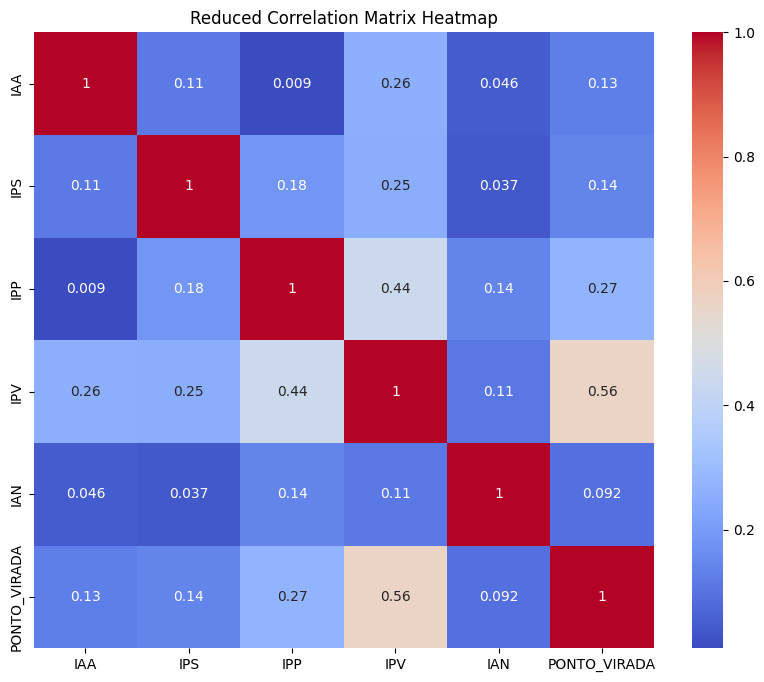

Columns removed: {'IEG', 'IDA', 'INDE'}
Remaining columns: Index(['IAA', 'IPS', 'IPP', 'IPV', 'IAN', 'PONTO_VIRADA'], dtype='object')


In [28]:
# Assuming df is your DataFrame
from matplotlib import pyplot as plt
import seaborn as sns


correlation_matrix = df_ponto_virada_to_predict.corr()

# Set a threshold for correlation
threshold = 0.8

# Identify highly correlated pairs
highly_correlated = []
for column in correlation_matrix.columns:
    for index in correlation_matrix.index:
        if abs(correlation_matrix.loc[index, column]) > threshold and column != index:
            highly_correlated.append((column, index))

# Determine columns to drop, ensuring each column is checked before dropping
columns_to_drop = set()

for column1, column2 in highly_correlated:
    # Add column2 to drop if it's still in the DataFrame
    if column2 in df_ponto_virada_to_predict.columns:
        columns_to_drop.add(column2)

# Drop the correlated columns from the DataFrame
df_ponto_virada_to_predict_reduced = df_ponto_virada_to_predict.drop(columns=columns_to_drop, errors='ignore')

# Visualize the reduced correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df_ponto_virada_to_predict_reduced.corr(), annot=True, cmap='coolwarm')
plt.title('Reduced Correlation Matrix Heatmap')
plt.show()

# Print the columns that were removed and the remaining columns
print(f"Columns removed: {columns_to_drop}")
print(f"Remaining columns: {df_ponto_virada_to_predict_reduced.columns}")

### Salvando os datasets com os dados que serão usados para treinar os modelos da BOLSA e do PONTO DE VIRADA

In [29]:
df_bolsa_predict.to_csv('output/df_bolsa_predict.csv', sep=',', index=False)
df_ponto_virada_to_predict.to_csv('output/df_ponto_virada_to_predict.csv', sep=',', index=False)

In [30]:
df_ponto_virada_to_predict_reduced.PONTO_VIRADA.value_counts()

PONTO_VIRADA
0    1932
1     315
Name: count, dtype: int64

In [31]:
df_ponto_virada_to_predict_reduced

,IAA,IPS,IPP,IPV,IAN,PONTO_VIRADA
0,8.50002,7.500,5.93750,7.750000,10.0,0
2,7.91667,7.500,8.12500,8.111113,10.0,0
3,8.00002,6.875,7.18750,7.750000,5.0,0
4,7.50002,7.500,8.43750,8.166665,10.0,0
7,8.33334,4.375,8.75000,8.944450,10.0,1
...,...,...,...,...,...,...
1341,7.91668,7.500,6.25000,7.500000,10.0,0
1342,7.41668,6.250,6.25000,7.444443,5.0,0
1345,9.00002,7.500,5.62500,9.083340,5.0,1
1347,8.33334,5.625,6.71875,5.833328,5.0,0


### Normalizando os dados (Scaler) e gerando os arrays X e Y

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X = df_ponto_virada_to_predict_reduced.drop('PONTO_VIRADA', axis=1)
Y = df_ponto_virada_to_predict_reduced['PONTO_VIRADA']

# Convert categorical features to numeric using one-hot encoding, if needed
X = pd.get_dummies(X)

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Ensure X and Y are numpy arrays
X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

# Verify shape and type of the arrays after conversion
print(f"X shape: {X.shape}, X dtype: {X.dtype}")
print(f"Y shape: {Y.shape}, Y dtype: {Y.dtype}")
print("Sample of X data:\n", X[:5])
print("Sample of Y data:\n", Y[:5])

# Check for any remaining non-numeric or NaN values
assert np.issubdtype(X.dtype, np.number), "X contains non-numeric values."
assert not np.isnan(X).any(), "X contains NaN values."
assert np.issubdtype(Y.dtype, np.number), "Y contains non-numeric values."
assert not np.isnan(Y).any(), "Y contains NaN values."


# Check for any non-numeric or NaN values
print(f"X dtype: {X.dtype}, Y dtype: {Y.dtype}")
print(f"Any NaN in X: {np.isnan(X).any()}, Any NaN in Y: {np.isnan(Y).any()}")

X

X shape: (2247, 5), X dtype: float32
Y shape: (2247,), Y dtype: float32
Sample of X data:
 [[0.8500003  0.75       0.59375    0.6999991  1.        ]
 [0.79166543 0.75       0.8125     0.7481474  1.        ]
 [0.8000004  0.6875     0.71875    0.6999991  0.33333334]
 [0.7500005  0.75       0.84375    0.7555543  1.        ]
 [0.83333236 0.4375     0.875      0.85925883 1.        ]]
Sample of Y data:
 [0. 0. 0. 0. 1.]
X dtype: float32, Y dtype: float32
Any NaN in X: False, Any NaN in Y: False


array([[0.8500003 , 0.75      , 0.59375   , 0.6999991 , 1.        ],
       [0.79166543, 0.75      , 0.8125    , 0.7481474 , 1.        ],
       [0.8000004 , 0.6875    , 0.71875   , 0.6999991 , 0.33333334],
       ...,
       [0.9000002 , 0.75      , 0.5625    , 0.8777775 , 0.33333334],
       [0.83333236, 0.5625    , 0.671875  , 0.44444308, 0.33333334],
       [0.79166543, 0.75      , 0.75      , 0.46666506, 0.33333334]],
      dtype=float32)

### Gerando os arrays de treino e de teste para treinar e testar o modelo.

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(len(Y_train))

1572


In [34]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, Y_train)

In [35]:
df_ponto_virada_to_predict_reduced['PONTO_VIRADA'].value_counts()

PONTO_VIRADA
0    1932
1     315
Name: count, dtype: int64

In [36]:
X_test.dtype

dtype('float32')

####   - **"Inicializando"**, **"treinando"**, **"fazendo previsões com os dados de teste"** e **"avaliando"** o modelo de classificação **RANDOM FOREST** a ser usado nas previsões de PONTO DE VIRADA.

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train_res, y_train_res)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
report = classification_report(Y_test, y_pred)


In [38]:
accuracy

0.9777777777777777

In [39]:
print(report)

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       581
         1.0       0.88      0.98      0.92        94

    accuracy                           0.98       675
   macro avg       0.94      0.98      0.96       675
weighted avg       0.98      0.98      0.98       675



Confusion Matrix:
 [[568  13]
 [  2  92]]


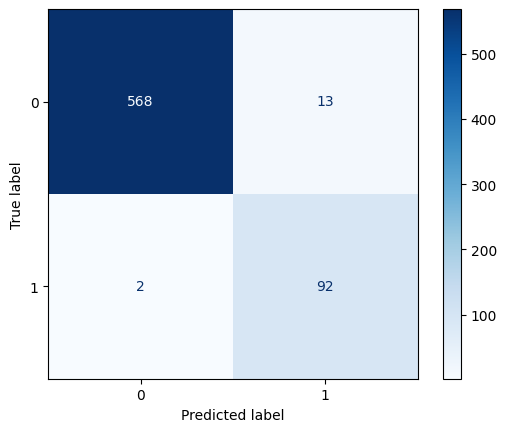

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Generate the confusion matrix
cm = confusion_matrix(Y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)

# Optionally, use ConfusionMatrixDisplay for a visual representation
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots()
disp.plot(ax=ax, cmap=plt.cm.Blues)

### Analisando a importância de cada um dos Indicadores no Modelo Randon Forest

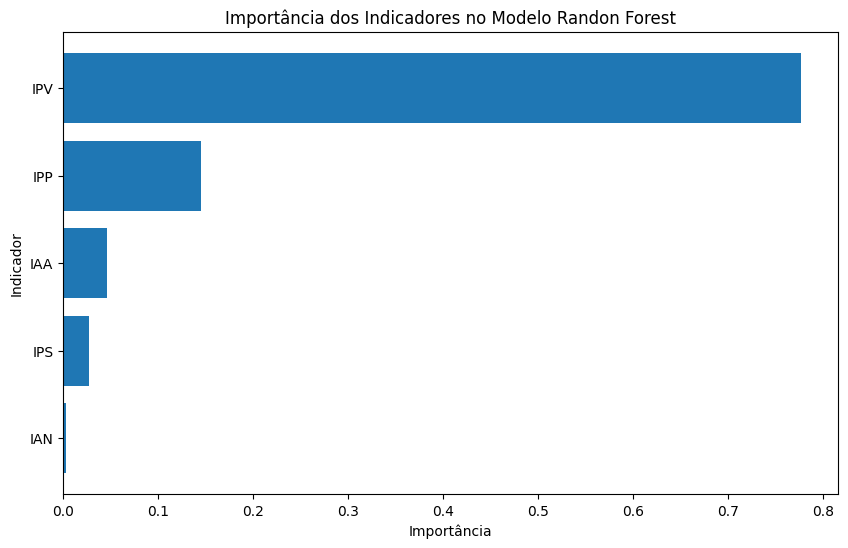

In [41]:
import matplotlib.pyplot as plt

feature_names = df_ponto_virada_to_predict_reduced.drop('PONTO_VIRADA', axis=1).columns

# Get feature importances
importances = model.feature_importances_
features = feature_names

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.to_csv('output/ponto_virada_feature_importance.csv', sep=',', index=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importância')
plt.ylabel('Indicador')
plt.title('Importância dos Indicadores no Modelo Randon Forest')
plt.gca().invert_yaxis()
plt.show()

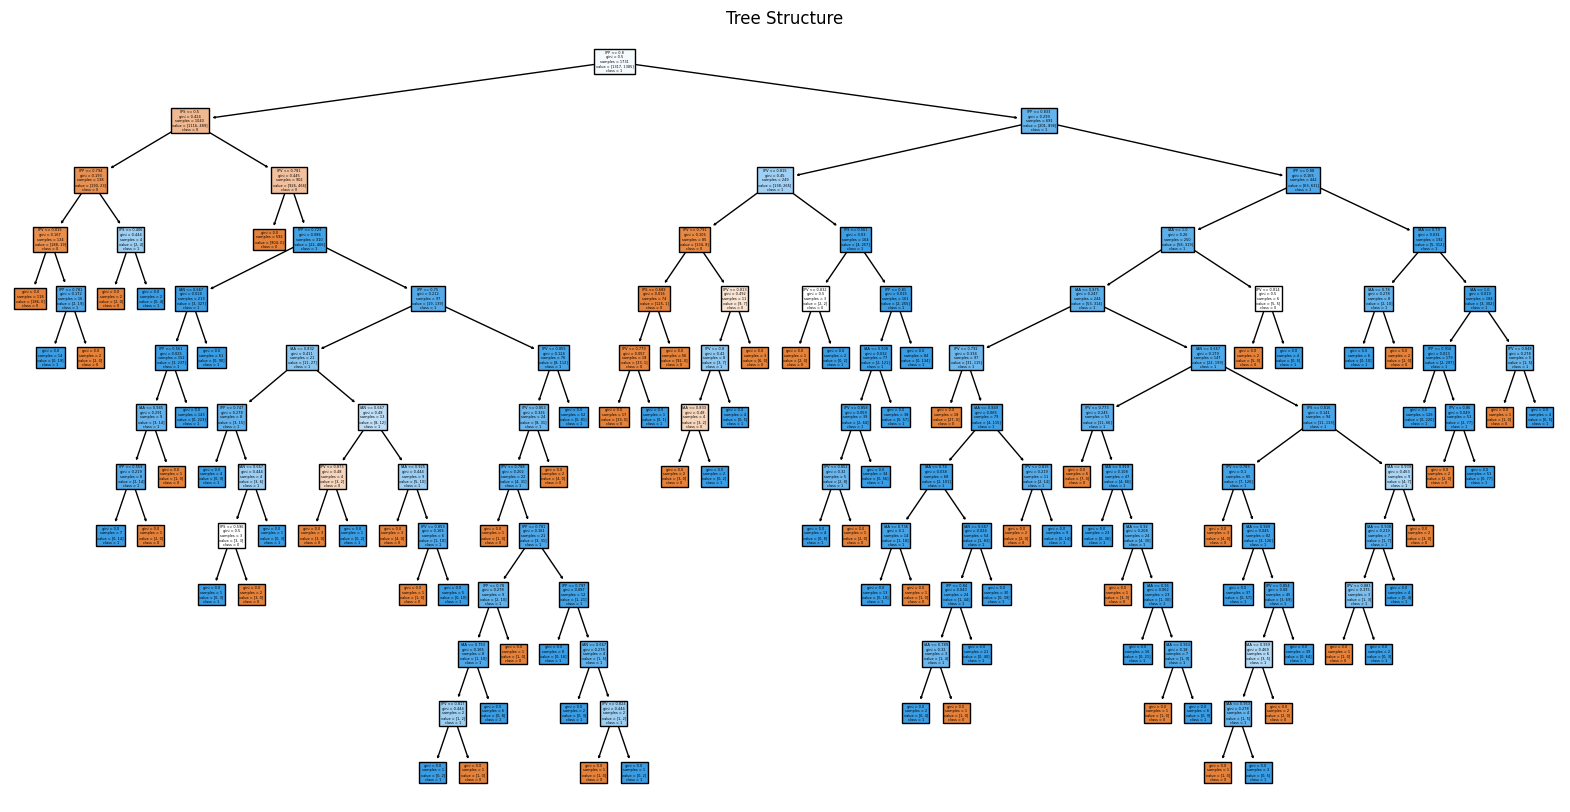

In [42]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], feature_names=feature_names, class_names=pd.Index(['0', '1']), filled=True)
plt.title('Tree Structure')
plt.show()

In [43]:
# get row where student passed
df_ponto_virada_to_predict_reduced.query('PONTO_VIRADA == 1')

,IAA,IPS,IPP,IPV,IAN,PONTO_VIRADA
7,8.33334,4.375,8.750000,8.944450,10.0,1
10,9.00002,8.125,10.000000,10.000010,10.0,1
27,9.58335,6.875,10.000000,9.944453,10.0,1
54,0.00000,7.500,8.281250,8.666667,5.0,1
74,10.00002,10.000,9.375000,9.750010,10.0,1
...,...,...,...,...,...,...
1218,6.66666,7.500,6.041667,8.500005,10.0,1
1291,10.00002,8.750,8.593750,8.500003,10.0,1
1332,9.00002,7.500,6.041667,8.500000,10.0,1
1333,9.50002,7.500,6.041667,9.000007,10.0,1


### Simulando casos para testar o modelo preditivo de alcance do PONTO DE VIRADA.


In [44]:
import numpy as np

# Create mock data with the same feature names as the original data
mock_data = pd.DataFrame({
    'IAA': [8.33],
    'IPS': [4.375],
    'IPP': [8.75],
    'IPV': [8.95],
    'IAN': [10.0],
})

# Preprocess the mock data using the scaler
mock_data_scaled = scaler.transform(mock_data)

# Predict using the loaded model
mock_prediction = model.predict(mock_data_scaled)

if mock_prediction[0] == 1:
    print("O aluno apresenta alta probabilidade de subir de nível.")
else:
    print("O aluno apresenta baixa probabilidade de subir de nível.")

O aluno apresenta alta probabilidade de subir de nível.


### Salvando o modelo do Ponto de Virada no formato .pkl para fazer o DEPLOY no Streamlit

In [45]:
import joblib

# Save the model
joblib.dump(scaler, 'model/random_forest_ponto_virada_scaler.pkl')
joblib.dump(model, 'model/random_forest_ponto_virada_model.pkl')


['model/random_forest_ponto_virada_model.pkl']

## Construção do modelo preditivo p/saber se o aluno pode receber uma BOLSA DE ESTUDOS.

### Data Preparation:

Split the data into features (X) and target (y).
Normalize the features to ensure that all the input data has a similar scale.
Split the data into training and testing sets.

### Handling Imbalance:

Use techniques like oversampling (e.g., SMOTE) or adjusting class weights during model training.

### Model Creation:

Build a neural network using a library like TensorFlow/Keras.
Define the input layer, hidden layers, and output layer.
Use an appropriate activation function for the output layer (e.g., sigmoid for binary classification).

### Model Training:

Compile the model using an optimizer (e.g., Adam) and a suitable loss function (e.g., binary crossentropy).
Train the model on the training data.

### Model Evaluation:

Evaluate the model's performance on the test set using metrics like accuracy, precision, recall, and the ROC-AUC score.

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [47]:
df_perfil_receber_bolsa_estudos = pd.read_csv('./output/df_bolsa_predict.csv')
df_perfil_receber_bolsa_estudos.head()

,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDE,INDICADO_BOLSA
0,10.00002,7.581705,7.5,8.816667,5.625000,7.916665,5.0,7.675509,1
1,10.00002,8.071429,7.5,5.083333,6.250000,8.055553,5.0,7.117065,0
2,6.41668,8.557505,7.5,7.083333,6.458333,7.833337,5.0,7.232336,0
3,9.00002,9.333333,7.5,5.500000,6.250000,7.500000,10.0,7.741669,0
4,10.00002,9.314954,7.5,5.583333,5.937500,7.916670,5.0,7.406743,0


In [48]:
columns = df_perfil_receber_bolsa_estudos.columns.difference(['INDICADO_BOLSA'])
good_grades = np.random.uniform(8, 10, size=(200, len(columns)))
good_grades = pd.DataFrame(good_grades, columns=columns)
good_grades['INDICADO_BOLSA'] = 1
good_grades.head()

,IAA,IAN,IDA,IEG,INDE,IPP,IPS,IPV,INDICADO_BOLSA
0,8.011886,9.244513,9.321831,8.223562,8.323048,8.624358,9.988796,8.772856,1
1,8.454682,9.198061,9.456844,9.638870,8.848712,9.487787,8.888217,9.196719,1
2,8.130541,8.474241,8.638972,9.755331,8.970216,8.272558,8.530763,8.662835,1
3,8.135531,9.789784,9.774204,8.926947,9.204341,9.816876,9.818762,9.750222,1
4,9.196029,9.810726,9.891330,8.330426,9.949410,8.679639,9.684866,8.784193,1


In [49]:
bad_grades = np.random.uniform(0, 5, size=(400, len(columns)))
bad_grades = pd.DataFrame(bad_grades, columns=columns)
bad_grades['INDICADO_BOLSA'] = 0
bad_grades

,IAA,IAN,IDA,IEG,INDE,IPP,IPS,IPV,INDICADO_BOLSA
0,3.430484,2.136451,1.234458,1.090087,3.429035,2.107057,4.250972,2.909478,0
1,2.745984,0.061455,2.929310,1.338229,3.727010,2.904663,1.073097,4.516583,0
2,1.950134,3.440047,0.068799,4.884486,1.337874,0.856063,4.690824,4.538042,0
3,0.491413,1.535489,4.683260,3.205365,0.261117,4.424144,4.750266,2.867655,0
4,4.922352,0.917265,4.768174,2.481885,0.387257,2.833941,1.867752,3.231354,0
...,...,...,...,...,...,...,...,...,...
395,2.579989,1.077820,3.100100,4.181775,1.126203,0.821844,4.916712,3.374703,0
396,0.761643,2.499320,2.176194,3.553808,4.115303,1.769885,1.751719,0.213352,0
397,4.319294,2.380297,4.194183,0.361362,1.705706,2.203248,4.879206,0.942816,0
398,1.681621,2.567719,1.374577,4.101116,2.074030,4.196266,1.444729,0.369845,0


In [50]:
df_perfil_receber_bolsa_estudos_final = pd.concat([df_perfil_receber_bolsa_estudos, good_grades, bad_grades], ignore_index=True)

df_perfil_receber_bolsa_estudos_final

,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDE,INDICADO_BOLSA
0,10.000020,7.581705,7.500000,8.816667,5.625000,7.916665,5.000000,7.675509,1
1,10.000020,8.071429,7.500000,5.083333,6.250000,8.055553,5.000000,7.117065,0
2,6.416680,8.557505,7.500000,7.083333,6.458333,7.833337,5.000000,7.232336,0
3,9.000020,9.333333,7.500000,5.500000,6.250000,7.500000,10.000000,7.741669,0
4,10.000020,9.314954,7.500000,5.583333,5.937500,7.916670,5.000000,7.406743,0
...,...,...,...,...,...,...,...,...,...
1457,2.579989,4.181775,4.916712,3.100100,0.821844,3.374703,1.077820,1.126203,0
1458,0.761643,3.553808,1.751719,2.176194,1.769885,0.213352,2.499320,4.115303,0
1459,4.319294,0.361362,4.879206,4.194183,2.203248,0.942816,2.380297,1.705706,0
1460,1.681621,4.101116,1.444729,1.374577,4.196266,0.369845,2.567719,2.074030,0


In [51]:
print(df_perfil_receber_bolsa_estudos_final['INDICADO_BOLSA'].value_counts())

INDICADO_BOLSA
0    1130
1     332
Name: count, dtype: int64


In [52]:
# features
X = df_perfil_receber_bolsa_estudos_final[df_perfil_receber_bolsa_estudos_final.columns.difference(['INDICADO_BOLSA'])]
# targets
y = df_perfil_receber_bolsa_estudos_final['INDICADO_BOLSA']

X.size, X_train.size

(11696, 7860)

In [62]:
# Split the resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

In [63]:
y_test.value_counts()

INDICADO_BOLSA
0    226
1     67
Name: count, dtype: int64

In [64]:
scaler = StandardScaler()
scaler.fit(X_train)
scaler.fit(X_test)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
X_train.shape, X_test.shape


((1169, 8), (293, 8))

####   - **"Inicializando"**, **"treinando"**, **"fazendo previsões com os dados de teste"** e **"avaliando"** o modelo de classificação **RANDOM FOREST** a ser usado nas previsões de concessão de BOLSA DE ESTUDOS.

In [66]:
from tensorflow.keras.callbacks import EarlyStopping

# Reshape y_train and y_test for binary classification
y_train = np.asarray(y_train).reshape((-1, 1))
y_test = np.asarray(y_test).reshape((-1, 1))

# Define input and output shapes
input_shape = X_train.shape[1]    # Variáveis de entrada
output_shape = y_train.shape[1]   # Classe preditora
batch_size = 32

# Step 3: Model Creation with Input layer
model = Sequential([
    Dense(batch_size, input_shape=(input_shape,),activation='relu'),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(output_shape, activation='sigmoid')
])

# Step 4: Model Training
epoch = 2000
learning_rate = 0.00002
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

history = model.fit(X_train, y_train, epochs=epoch, shuffle=True, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping],  verbose=0)

# Step 5: Model Evaluation
y_pred = model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)

# Calculate metrics
classification_rep = classification_report(y_test, y_pred_class)
conf_matrix = confusion_matrix(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred)

classification_rep, conf_matrix, roc_auc

C:\Users\ponsoni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 644: early stopping
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


('              precision    recall  f1-score   support\n\n           0       0.90      0.94      0.92       226\n           1       0.77      0.64      0.70        67\n\n    accuracy                           0.87       293\n   macro avg       0.83      0.79      0.81       293\nweighted avg       0.87      0.87      0.87       293\n',
 array([[213,  13],
        [ 24,  43]], dtype=int64),
 0.9340906089023907)

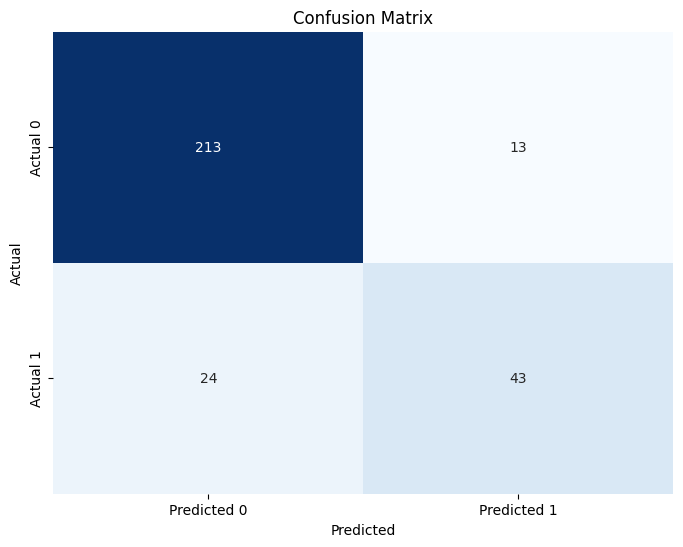

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [69]:
model_training_data_hist = pd.DataFrame(history.history)
model_training_data_hist

,accuracy,loss,val_accuracy,val_loss
0,0.650984,0.663162,0.737201,0.630217
1,0.603935,0.694969,0.744027,0.624690
2,0.632164,0.691189,0.740614,0.619206
3,0.629598,0.666575,0.740614,0.613916
4,0.644140,0.674244,0.744027,0.608793
...,...,...,...,...
639,0.882806,0.249090,0.873720,0.266953
640,0.870830,0.273961,0.873720,0.266916
641,0.875107,0.267196,0.873720,0.266888
642,0.870830,0.257464,0.873720,0.266896


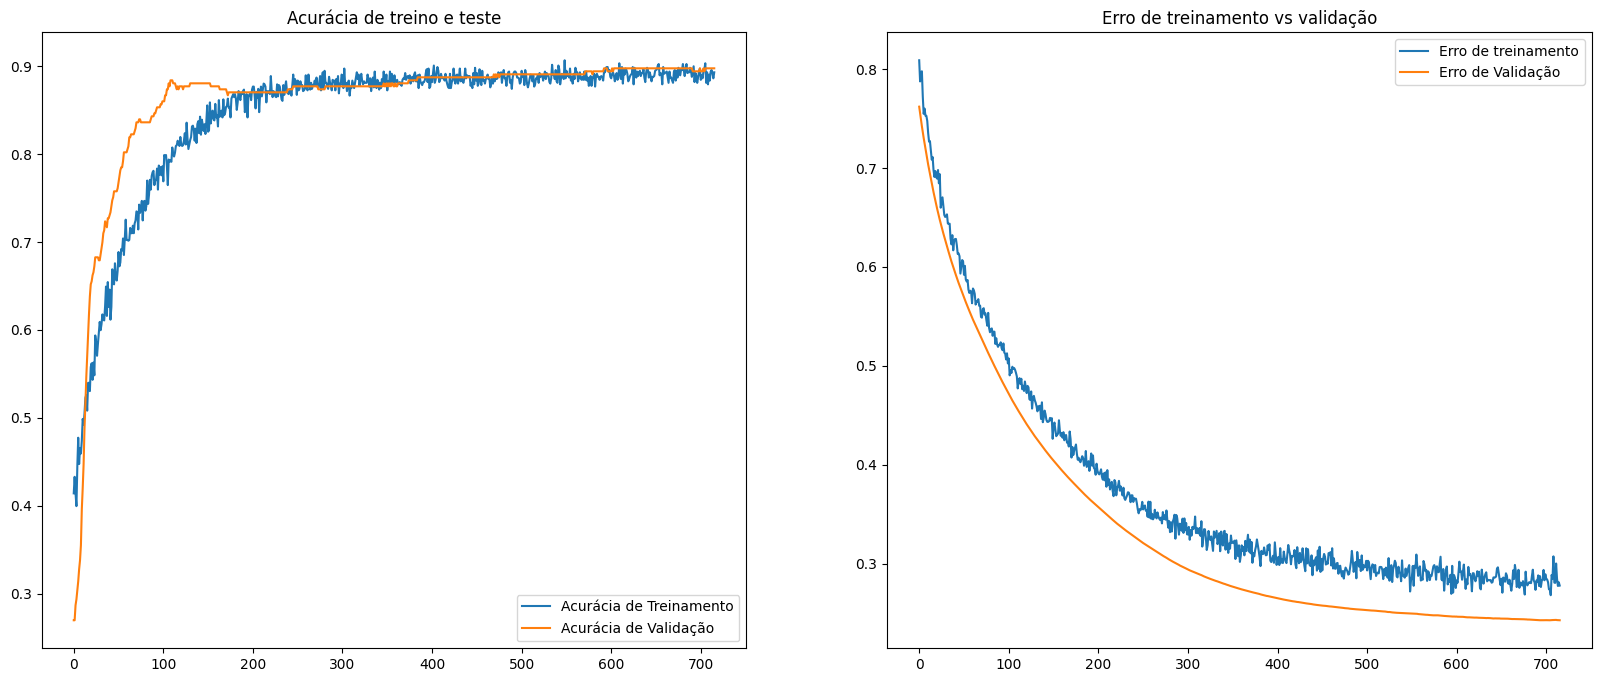

In [98]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Use the length of the training history to set the range
epochs_range = range(len(train_acc))

# Plot Acurácia
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Acurácia de Treinamento')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de treino e teste')

# Plot Erro de treinamento
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Erro de treinamento')
plt.plot(epochs_range, val_loss, label='Erro de Validação')
plt.legend(loc='upper right')
plt.title('Erro de treinamento vs validação')
plt.show()


In [71]:
df_perfil_receber_bolsa_estudos

,IAA,IEG,IPS,IDA,IPP,IPV,IAN,INDE,INDICADO_BOLSA
0,10.00002,7.581705,7.500,8.816667,5.625000,7.916665,5.0,7.675509,1
1,10.00002,8.071429,7.500,5.083333,6.250000,8.055553,5.0,7.117065,0
2,6.41668,8.557505,7.500,7.083333,6.458333,7.833337,5.0,7.232336,0
3,9.00002,9.333333,7.500,5.500000,6.250000,7.500000,10.0,7.741669,0
4,10.00002,9.314954,7.500,5.583333,5.937500,7.916670,5.0,7.406743,0
...,...,...,...,...,...,...,...,...,...
857,7.91668,9.666667,7.500,7.750000,6.250000,7.500000,10.0,8.150001,0
858,7.41668,6.470435,6.250,2.000000,6.250000,7.444443,5.0,5.674644,0
859,9.00002,9.031839,7.500,9.000000,5.625000,9.083340,5.0,8.135538,0
860,8.33334,9.178030,5.625,5.900000,6.718750,5.833328,5.0,6.749981,0


In [72]:
scaler.feature_names_in_

array(['IAA', 'IAN', 'IDA', 'IEG', 'INDE', 'IPP', 'IPS', 'IPV'],
      dtype=object)

### Simulando casos para testar o modelo preditivo para concessão de BOLSA DE ESTUDOS.

In [77]:
# Create mock data
mock_data = pd.DataFrame({
    'IAA': [10],
    'IEG': [9.16],
    'IPS': [7.50],
    'IDA': [8.89],
    'IPP': [8.12],
    'IPV': [8.21],
    'IAN': [8.0],
    'INDE': [8.95]
})

# Ensure the mock data columns match the original data used to fit the scaler
mock_data = mock_data[scaler.feature_names_in_]

# Preprocess the mock data using the scaler
mock_data_scaled = scaler.transform(mock_data)

# Predict using the loaded model
mock_prediction = model.predict(mock_data_scaled)

mock_prediction.flatten().round()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


array([1.], dtype=float32)

In [78]:
# Create mock data
mock_data = pd.DataFrame({
    'IAA': [3],
    'IEG': [4.16],
    'IPS': [7.50],
    'IDA': [0.89],
    'IPP': [8.12],
    'IPV': [8.21],
    'IAN': [2.0],
    'INDE': [8.95]
})

# Ensure the mock data columns match the original data used to fit the scaler
mock_data = mock_data[scaler.feature_names_in_]

# Preprocess the mock data using the scaler
mock_data_scaled = scaler.transform(mock_data)

# Predict using the loaded model
mock_prediction = model.predict(mock_data_scaled)

mock_prediction.flatten().round()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([0.], dtype=float32)

### Salvando o modelo BOLSA DE ESTUDOS no formato .pkl para fazer o DEPLOY no Streamlit

In [145]:
import joblib

model_training_data_hist.to_csv('model/model_training_data_hist.csv', index=None, sep=';')

# Save the model
joblib.dump(scaler, 'model/perfil_receber_bolsa_estudos_scaler.pkl')
joblib.dump(model, 'model/perfil_receber_bolsa_estudos_model.pkl')



['model/perfil_receber_bolsa_estudos_model.pkl']